- Jumble things (with randomization)
- Train-validation-test splits with continuous training during execution (During training we'll use the jumble)
- Pretrain actor network
  - Freeze the actor network and train the critic network
  - Commence full QAC training
- Check the policy loss metric, just in case it is not accurate (Reference other works)
- Consider SAC -> Has normal component, hopefully help with exploration
- Could also change the sample size from 20 and vary it down to 1, consider some form of RNN if possible (idk how to do that with batch training though)

  
Sunday:
- Need to figure out MLflow logging
- Tensorboard: https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

Monday:
- PPO
- Long-only policy
- Recreating the table on Slide 41 of 56 from this set of lecture slides would be good for our purposes https://www.davidsilver.uk/wp-content/uploads/2020/03/FA.pdf
- Soft Actor Critic: https://arxiv.org/abs/1910.07207
- Do some feature selection


In [1]:
import os
import random
from collections import namedtuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.distributions.categorical import Categorical

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize_scalar

from LOB_analysis import *

%matplotlib inline

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
MARKET_OPEN = '9:30'
MARKET_CLOSE = '16:00'

message = pd.read_pickle(r"../data/AMD_jan_msg.pickle")
orderbook = pd.read_pickle(r"../data/AMD_jan_odb.pickle")

market_open_idx = message.set_index('time').index.indexer_between_time(MARKET_OPEN, MARKET_CLOSE)

message = message.iloc[market_open_idx, :].reset_index(drop=True)
orderbook = orderbook.iloc[market_open_idx, :].reset_index(drop=True)
data = generate_data(message, orderbook, granularity='30 s', standardize_offset = 1) # Standardize by data of 1 day prior

bids = data.loc[:, 'bid']
asks = data.loc[:, 'ask']
data = data.drop(['bid', 'ask'], axis=1)

## 3. Create features

**I do not know if standardization is actually a good thing. [CHECK - Ask prof too]**  
Standardization will be done using a small window of previous events. This is because the statistical properties change as time moves on, so we standardize w.r.t small prior windows. Standardization benefits ML training since values will stradle 0 and not be too far from it.  

**Check if we should reindex time-series data with forward padding and explicitly 0-labels given to these regions.**

**BE CAREFUL OF THE CURSE OF DIMENSIONALITY**
To understand if the curse of dimensionality is affecting performance, rerun the exact same experiments with fewer features and see if profitability increases.


In [4]:
"""
For optimizing the threshold value to produce balanced class labels.

Use with scipy.optimize.minimize_scalar
"""
def label_eval(threshold, time_horizon = 50):
    labels = get_label(data.mid_price, time_horizon = time_horizon, threshold = threshold)
    counts = labels.value_counts()
    return -(counts / counts.sum()).min()

threshold = minimize_scalar(label_eval, bounds=(0, 2)).x
labels = get_label(data.mid_price, time_horizon=50, threshold=threshold)

In [5]:
SAMPLE_SIZE = 20

In [6]:
# # Normalize BEFORE time series sampling
# NUM_DATA_COLS = data.shape[1]
# bid_col_idx = data.columns.get_loc('bid')
# ask_col_idx = data.columns.get_loc('ask')

# curr_bid_idx = bid_col_idx + (NUM_DATA_COLS + 1) * (SAMPLE_SIZE - 1)
# curr_ask_idx = ask_col_idx + (NUM_DATA_COLS + 1) * (SAMPLE_SIZE - 1)

In [7]:
X, y, bids, asks = generate_time_series_samples(data, labels, bids, asks, SAMPLE_SIZE) # This fn performs dropna
X.shape

(12130, 20, 58)

In [8]:
assert (y.index == asks.index).all()
assert (y.index == bids.index).all()

In [9]:
X_flatten = X.reshape(X.shape[0], -1)
X_flatten.shape

(12130, 1160)

In [10]:
X_torch = torch.ones((X_flatten.shape[0], X_flatten.shape[1] + 1))
X_torch[:, :-1] = torch.tensor(X_flatten)
X_torch = X_torch.to(device)
X_torch.shape

torch.Size([12130, 1161])

In [11]:
NUM_DATA_COLS = X_torch.shape[1]

In [12]:
class CriticNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.value = nn.Sequential(
            nn.Linear(NUM_DATA_COLS, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )
    
    def forward(self):
        raise NotImplementedError
    
    def get_value(self, state):
        return self.value(state)

Note that actions are:
- 0: Short   (Have -1 asset)
- 1: Neutral (Have 0 asset)
- 2: Long    (Have 1 asset)

In [13]:
class ActorNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.action = nn.Sequential(
            nn.Linear(NUM_DATA_COLS, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
        )

    def forward(self):
        raise NotImplementedError

    def get_next_portfolio(self, state):
        with torch.no_grad():
            logits = self.action(state)
            probs = Categorical(logits=logits)
            action = probs.sample()
        return action
    
    def get_log_prob(self, prev_state, curr_state):
        logits = self.action(prev_state)
        dist = Categorical(logits=logits)
        action = curr_state[..., -1]
        return dist.log_prob(action)

In [14]:
def get_reward(prev_state, curr_state, prev_ask, prev_bid, curr_ask, curr_bid, prev_action_idx=-1, trading_fee=1e-4, neutral_penalty=1e-6):
    valid_actions = [0, 1, 2]
    assert (prev_state.dim() == 1) and (curr_state.dim() == 1), "State provided is not 1 dimensional"
    assert (prev_state[prev_action_idx] in valid_actions) and (curr_state[prev_action_idx] in valid_actions), "Action provided is not in [0, 1, 2] range"
    
    prev_is_neutral = prev_state[prev_action_idx] == 1
    curr_is_neutral = curr_state[prev_action_idx] == 1
    
    spread = (prev_ask - prev_bid).item()
    
    if curr_is_neutral:
        if prev_is_neutral:
            # Neutral -> Neutral
            return -neutral_penalty

        if not prev_is_neutral:
            # Active -> Neutral
            return -(spread + trading_fee)
    
    # Here onwards current portfolio is active
    curr_is_long = curr_state[prev_action_idx] == 2 # True -> Long, False -> Short
    price_change = curr_ask - prev_ask if curr_is_long else prev_bid - curr_bid
    price_change = price_change.item()
    portfolio_is_same = prev_state[prev_action_idx] == curr_state[prev_action_idx]
    
    if prev_is_neutral:
        # Neutral -> Active
        return -trading_fee + price_change
    
    if not prev_is_neutral:
        if portfolio_is_same:
            # Active -> Active
            return price_change
        else:
            # Active -> -Active
            return -(spread + trading_fee) - trading_fee + price_change

In [15]:
Experience = namedtuple("Experience", ['state', 'next_state', 'reward'])

In [16]:
class ExperienceReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.count = 0
    
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.count % self.capacity] = experience
        self.count += 1
    
    def sample(self, batch_size):
        batch = Experience(*zip(*random.sample(self.memory, batch_size)))
        t1 = torch.stack(batch.state)
        t2 = torch.stack(batch.next_state)
        t3 = torch.tensor(batch.reward).unsqueeze(1).to(device)
        return Experience(state=t1, next_state=t2, reward=t3)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [17]:
Experience(1,2,3)

Experience(state=1, next_state=2, reward=3)

In [18]:
X_train, X_test, bid_train, bid_test, ask_train, ask_test = train_test_split(X_torch, bids, asks, shuffle=False, test_size=0.2)

State representation:

- At any current point we want to know our current portfolio
- The action is how we want to the new portfolio that we want, we will limit our portfolio (and hence actions) to -1, 0, and 1 quantity of the asset  
- We look at the next time step and get reward from the action we took

This neutral penalty seems to work: $0.0001 * 10^{epoch}$

In [ ]:
policy = ActorNetwork().to(device)
policy.train()

critic = CriticNetwork().to(device)
critic.train()

critic_frozen = CriticNetwork().to(device)
critic_frozen.load_state_dict(critic.state_dict())
critic_frozen.eval();

value_fn_losses = []
policy_losses = []
reward_history = [0]    # 0: Just so that len(reward_history) == len(portfolio_history)
portfolio_history = [1] # 1: Starting portfolio (neutral), possble portfolios are [0, 1, 2] i.e. [short, neutral, long]

memory = ExperienceReplayMemory(16384)

lr = 0.01
gamma = 0.99       # Discounted rate of future returns
batch_size = 256   # Train size
epochs = 10
weight_update_interval = 1
frozen_update_interval = 256

policy_optimizer = optim.Adam(params=policy.parameters(), lr=lr)
critic_optimizer = optim.Adam(params=critic.parameters(), lr=lr)

i = 0
for epoch in range(epochs):
    curr_state = X_train[0].clone() # Clone copies but maintains grad if one exists
    curr_bid, curr_ask = bid_train[0], ask_train[0]
    for j in range(1, X_train.shape[0]):
        next_state, next_bid, next_ask = X_train[j, ...], bid_train[j], ask_train[j]
        # Do not modify our training data
        next_state = next_state.clone()
        
        # Update the next_state with the new portfolio
        portfolio = policy.get_next_portfolio(curr_state)
        next_state[-1] = portfolio
        
        reward = get_reward(curr_state, next_state, prev_bid=curr_bid, prev_ask=curr_ask, curr_bid=next_bid, curr_ask=next_ask, trading_fee=1e-4, neutral_penalty=1e-4 * 10**epoch)
        reward_history.append(reward)
        portfolio_history.append(portfolio.item())
        experience = Experience(curr_state, next_state, reward)
        memory.push(experience)
        
        curr_state = next_state.clone()
        curr_bid, curr_ask = next_bid, next_ask
        i += 1
        print(f"Iteration: {i:>8}, Epoch: {epoch:>5}", end="\r")
        
        
        if memory.can_provide_sample(batch_size) and (i % weight_update_interval == 0):
            states, next_states, rewards = memory.sample(batch_size)
            
            with torch.no_grad():
                target = rewards + gamma * critic_frozen.get_value(next_states)
            advantages = target - critic.get_value(states)
            log_probs = policy.get_log_prob(states, next_states)
            assert (log_probs <= 0).all(), "There cannot be positive log probabilities"
            
            value_fn_loss = (advantages**2).mean()
            
            policy_loss = (log_probs * advantages.detach()).mean() * -1
            
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()
            
            critic_optimizer.zero_grad()
            value_fn_loss.backward()
            critic_optimizer.step()
            
            
            _portfolio_history = pd.Series(portfolio_history)
            num_trades = (_portfolio_history != _portfolio_history.shift(1).fillna(_portfolio_history[0])).sum()
            print(f"Iteration: {i:0>8,d}, Epoch: {epoch:>5}, Num trades: {num_trades:5}, Value function loss: {value_fn_loss.item():0>8,.5f}, Policy function loss: {policy_loss.item():0>8,.5f}", end="\r")
        if i % frozen_update_interval == 0:
            critic_frozen.load_state_dict(critic.state_dict())
            value_fn_losses.append(value_fn_loss)
            policy_losses.append(policy_loss)

In [ ]:
portfolio_history = pd.Series(portfolio_history)
(portfolio_history != portfolio_history.shift(1).fillna(portfolio_history[0])).sum()
# The number of trades executed:

In [51]:
portfolio_history.value_counts().plot(kind='bar')

In [52]:
pd.Series(reward_history).cumsum().plot()
plt.ylabel("Cumulative rewards")
plt.xlabel("Time step");

In [53]:
pd.Series(reward_history[:2000]).cumsum().plot()
plt.ylabel("Cumulative rewards")
plt.xlabel("Time step");

### Optional parameter save

In [30]:
torch.save(policy.state_dict(), r"../logs/policy_model.pt")
torch.save(policy.state_dict(), r"../logs/critic_model.pt")

# Some old results
When the neutral penalty was 1e-4

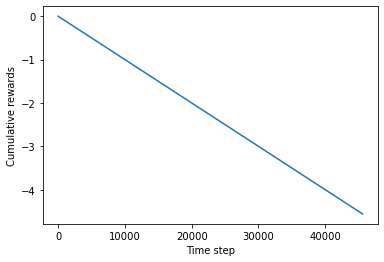

In [26]:
pd.Series(reward_history[2000:]).cumsum().plot()
plt.ylabel("Cumulative rewards")
plt.xlabel("Time step");

In [34]:
portfolio_history = pd.Series(portfolio_history)
(portfolio_history != portfolio_history.shift(1)).sum()
# The number of trades executed:

9

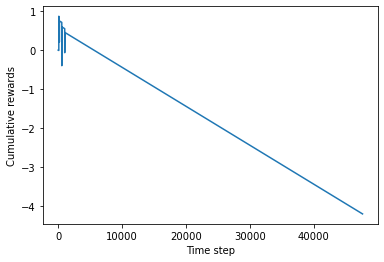

In [25]:
pd.Series(reward_history).cumsum().plot()
plt.ylabel("Cumulative rewards")
plt.xlabel("Time step");

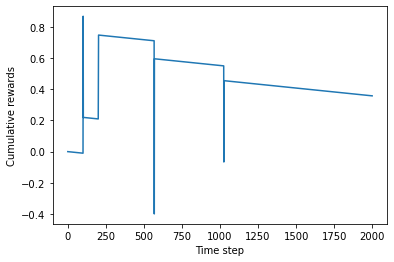

In [28]:
pd.Series(reward_history[:2000]).cumsum().plot()
plt.ylabel("Cumulative rewards")
plt.xlabel("Time step");

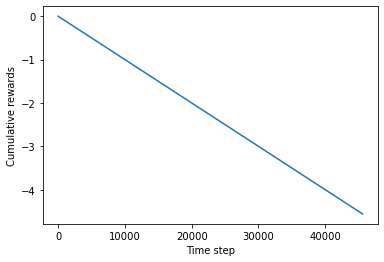

In [26]:
pd.Series(reward_history[2000:]).cumsum().plot()
plt.ylabel("Cumulative rewards")
plt.xlabel("Time step");

Final report
- Describe RL
- Describe LOB
- What metric are we trying to optimise
- Inputs
- Literature review
- Results